In [83]:
import numpy as np
import pandas as pd
import os

import sklearn.linear_model
import sklearn.pipeline
import sklearn.metrics

from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier

import matplotlib
import matplotlib.pyplot as plt

In [84]:
x_train_N = np.load("data_reviews/x_train_BERT_embeddings.npy")
y_train_N = pd.read_csv("data_reviews/y_train.csv").to_numpy()[:,0]

x_train_N, y_train_N = shuffle(x_train_N, y_train_N)

x_train_N.shape

(2400, 768)

In [101]:
def make_hyperparam_grid():

    hyperparam_grid = {}

    # hyperparam_grid["classifier__activation"] = ["identity", "logistic", "tanh", "relu"]
    # hyperparam_grid["classifier__solver"] = ["lbfgs", "sgd", "adam"]
    hyperparam_grid["classifier__alpha"] = np.logspace(-2, 2, 5)
    hyperparam_grid["classifier__hidden_layer_sizes"] = [(256,) * i for i in range(1, 6)]

    return hyperparam_grid

In [102]:
def make_classifier_pipeline(alpha=10.0, hidden_layer_sizes=(256, 256, 256)):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
            (
                "classifier",
                MLPClassifier(random_state=1, max_iter=100000, solver="adam", activation="relu", alpha=alpha, hidden_layer_sizes=hidden_layer_sizes),
            ),
        ]
    )

    return pipeline

In [110]:
alpha_values = np.logspace(-6, 6, 13)

x_valid = x_train_N[:480]
y_valid = y_train_N[:480]

x_train = x_train_N[480:]
y_train = y_train_N[480:]


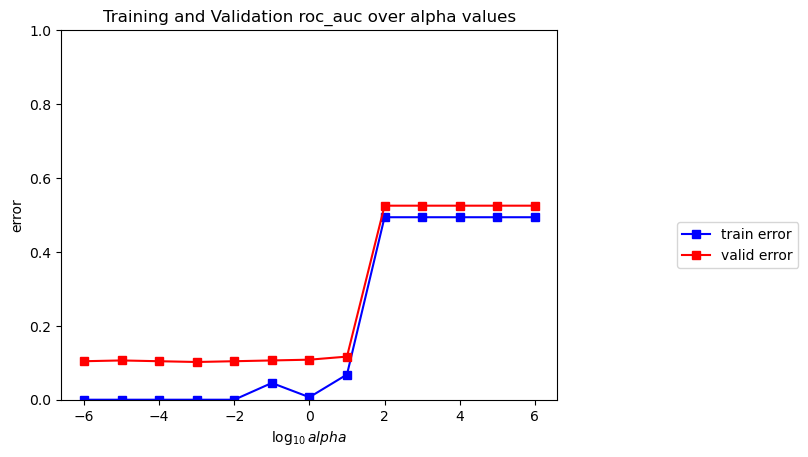

In [111]:

tr_err_for_alpha = []
va_err_for_alpha = []

for alpha in alpha_values:
    curr_pipeline = make_classifier_pipeline(alpha=alpha)
    curr_pipeline.fit(x_train, y_train)

    yhat_train = curr_pipeline.predict_proba(x_train)[:,1]
    yhat_valid = curr_pipeline.predict_proba(x_valid)[:,1]
    
    tr_err_for_alpha.append(sklearn.metrics.zero_one_loss(y_train, yhat_train >= 0.5))
    va_err_for_alpha.append(sklearn.metrics.zero_one_loss(y_valid, yhat_valid >= 0.5))


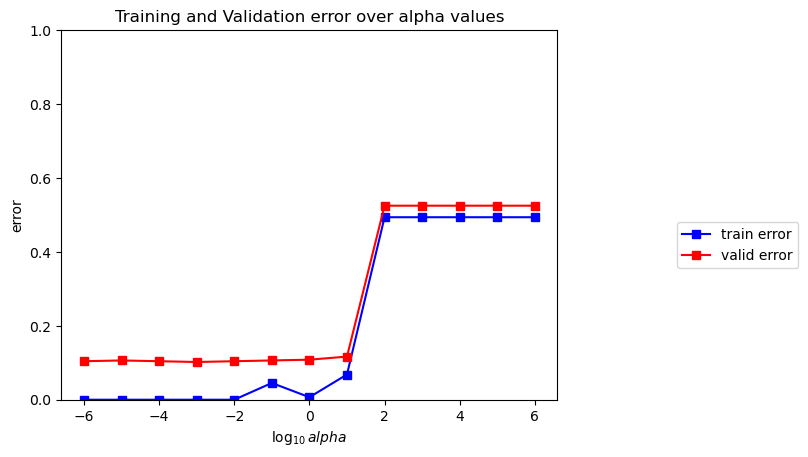

In [112]:

    
plt.title("Training and Validation error over alpha values");
plt.plot(np.log10(alpha_values), tr_err_for_alpha, 'bs-', label='train error')
plt.plot(np.log10(alpha_values), va_err_for_alpha, 'rs-', label='valid error')

plt.ylabel('error')
plt.xlabel("$\log_{10} alpha$");
plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
plt.ylim([0, 1.0]);

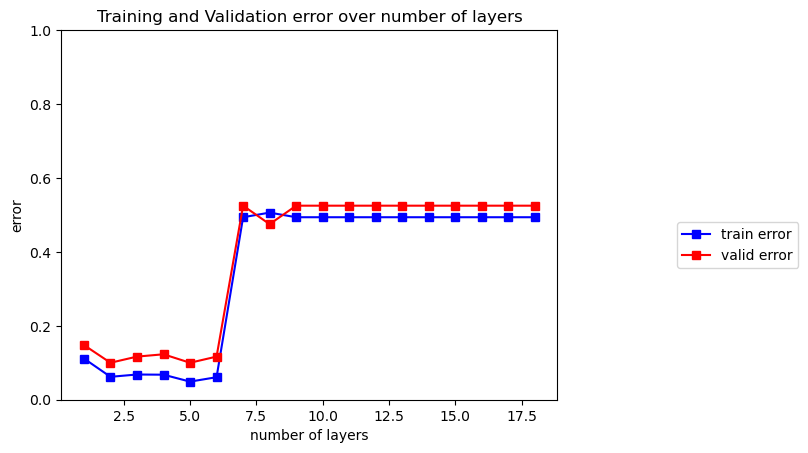

In [104]:
number_layers = [(256,)*i for i in range(1,19)]

tr_err_for_layers = []
va_err_for_layers = []

for layer in number_layers:
    curr_pipeline = make_classifier_pipeline(hidden_layer_sizes=layer)
    curr_pipeline.fit(x_train, y_train)

    yhat_train = curr_pipeline.predict_proba(x_train)[:,1]
    yhat_valid = curr_pipeline.predict_proba(x_valid)[:,1]
    
    tr_err_for_layers.append(sklearn.metrics.zero_one_loss(y_train, yhat_train >= 0.5))
    va_err_for_layers.append(sklearn.metrics.zero_one_loss(y_valid, yhat_valid >= 0.5))

    
plt.title("Training and Validation error over number of layers");
plt.plot([i for i in range(1,19)], tr_err_for_layers, 'bs-', label='train error')
plt.plot([i for i in range(1,19)], va_err_for_layers, 'rs-', label='valid error')

plt.ylabel('error')
plt.xlabel("number of layers");
plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
plt.ylim([0, 1.0]);

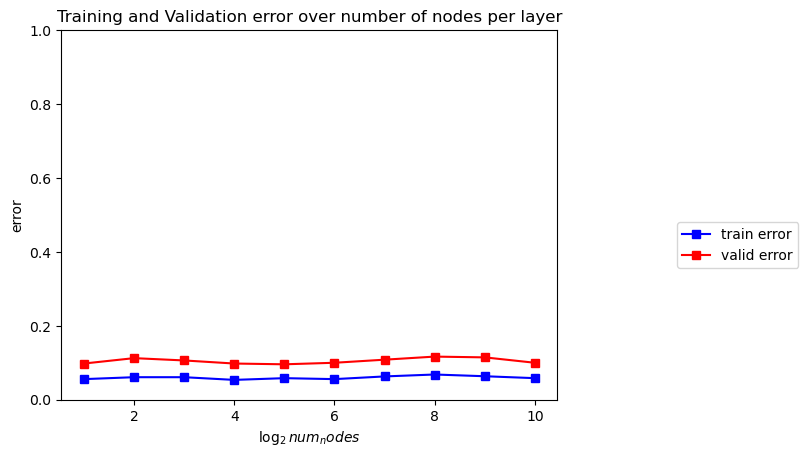

In [108]:
arr = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

number_nodes = [(elem,)*3 for elem in arr]

tr_err_for_nodes = []
va_err_for_nodes = []

for nodes in number_nodes:
    curr_pipeline = make_classifier_pipeline(hidden_layer_sizes=nodes)
    curr_pipeline.fit(x_train, y_train)

    yhat_train = curr_pipeline.predict_proba(x_train)[:,1]
    yhat_valid = curr_pipeline.predict_proba(x_valid)[:,1]
    
    tr_err_for_nodes.append(sklearn.metrics.zero_one_loss(y_train, yhat_train >= 0.5))
    va_err_for_nodes.append(sklearn.metrics.zero_one_loss(y_valid, yhat_valid >= 0.5))

    
plt.title("Training and Validation error over number of nodes per layer");
plt.plot(np.log2(arr), tr_err_for_nodes, 'bs-', label='train error')
plt.plot(np.log2(arr), va_err_for_nodes, 'rs-', label='valid error')

plt.ylabel('error')
plt.xlabel("$\log_{2} num_nodes$");
plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
plt.ylim([0, 1.0]);

In [109]:
print(number_nodes)

[(2, 2, 2), (4, 4, 4), (8, 8, 8), (16, 16, 16), (32, 32, 32), (64, 64, 64), (128, 128, 128), (256, 256, 256), (512, 512, 512), (1024, 1024, 1024)]


In [ ]:
pipeline = make_classifier_pipeline()
hyperparam_grid = make_hyperparam_grid()

grid_searcher = sklearn.model_selection.GridSearchCV(
    pipeline,
    hyperparam_grid,
    cv=5,
    scoring="roc_auc"
)


In [ ]:

grid_searcher.fit(x_train_N, y_train_N)


In [ ]:

print(f"best score: {grid_searcher.best_score_}")
print("best params:", grid_searcher.best_params_)

In [ ]:
pd.DataFrame(grid_searcher.cv_results_)

In [ ]:
x_test_N = np.load("data_reviews/x_test_BERT_embeddings.npy")

model = grid_searcher.best_estimator_

predictions = model.predict_proba(x_test_N)[:,1]

np.savetxt("yproba1_test.txt", predictions)
